# Часть 3. Преобразуем данные для машинного обучения. Построим простую модель

У нас теперь есть тренировочный набор, оформленный в таком же формате как и тест.  
Сделаем предобработку данных и попробуем сделать простое предсказение (baseline)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv')

In [3]:
print(f"{train.shape=}")
print(f"{test.shape=}")

train.shape=(36210, 35)
test.shape=(34686, 32)


## Для удобства работы объединим train и test в один набор

In [4]:
train.drop(['index',
            'location'], axis=1, inplace=True)
train['is_train'] = True
test['is_train'] = False
test['price'] = 0

# чтобы индексы теста не потерялись, а в трейне продолжилась нумерация
train.index = range(test.shape[0], test.shape[0]+train.shape[0]) 

df = test.append(train, verify_integrity=True)

In [5]:
df.shape

(70896, 34)

## Простая предобработка данных

In [6]:
def fill_na(df):
    df.loc[df.engineDisplacement == ' LTR', 'engineDisplacement'] = None
    df.loc[df.ПТС.isna(),'ПТС'] = 'Оригинал'
    df.loc[df.Владельцы.isna(),'Владельцы'] = 'Неизвестно'
    
def change_column_dtypes(df):
    df.engineDisplacement = df.engineDisplacement.str.replace('LTR','').astype(float)
    df.enginePower = df.enginePower.str.replace('N12','').astype(float)
    

In [7]:
fill_na(df)
change_column_dtypes(df)

## Анализируем полученный набор (еще раз)

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.head(3))

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,is_train,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2,105.0,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5.0,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110.0,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5.0,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8,152.0,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013.0,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5.0,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70896 entries, 0 to 70895
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              70896 non-null  object 
 1   brand                 70896 non-null  object 
 2   car_url               70896 non-null  object 
 3   color                 70896 non-null  object 
 4   complectation_dict    42628 non-null  object 
 5   description           69896 non-null  object 
 6   engineDisplacement    70841 non-null  float64
 7   enginePower           70896 non-null  float64
 8   equipment_dict        60900 non-null  object 
 9   fuelType              70896 non-null  object 
 10  image                 70896 non-null  object 
 11  mileage               70896 non-null  int64  
 12  modelDate             70896 non-null  float64
 13  model_info            70896 non-null  object 
 14  model_name            70896 non-null  object 
 15  name               

In [10]:
df.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description              1000
engineDisplacement         55
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                49577
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
is_train                    0
price     

### bodyType

In [11]:
df.bodyType.value_counts()

внедорожник 5 дв.          28277
седан                      24621
лифтбек                     4924
хэтчбек 5 дв.               3884
универсал 5 дв.             2490
минивэн                     1754
купе                        1578
компактвэн                   928
хэтчбек 3 дв.                855
пикап двойная кабина         569
внедорожник 3 дв.            248
купе-хардтоп                 217
кабриолет                    170
родстер                      150
фургон                       144
микровэн                      22
седан-хардтоп                 15
седан 2 дв.                   12
пикап одинарная кабина        11
лимузин                        9
пикап полуторная кабина        7
тарга                          4
внедорожник открытый           4
фастбек                        2
универсал 3 дв.1               1
Name: bodyType, dtype: int64

### brand

In [12]:
df.brand.value_counts()

BMW           8203
VOLKSWAGEN    8173
NISSAN        8014
MERCEDES      7918
TOYOTA        7430
AUDI          6878
MITSUBISHI    6232
SKODA         6163
VOLVO         4259
HONDA         3148
LEXUS         2387
INFINITI      2091
Name: brand, dtype: int64

### color

In [13]:
df.color.value_counts()

чёрный         23823
белый          13183
серый          12174
синий           6932
серебристый     4113
красный         3061
зелёный         1833
коричневый      1501
золотистый      1157
голубой          874
фиолетовый       639
бежевый          639
жёлтый           397
оранжевый        294
пурпурный        254
розовый           22
Name: color, dtype: int64

### engineDisplacement

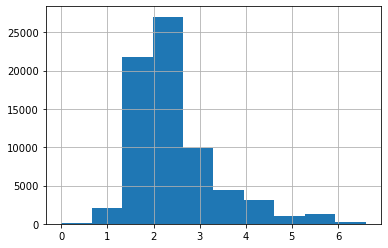

In [14]:
df.engineDisplacement.hist();

### enginePower

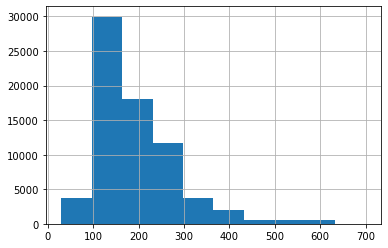

In [15]:
df.enginePower.hist();

### fuelType

In [16]:
df.fuelType.value_counts()

бензин     58030
дизель     12211
гибрид       529
электро      114
газ           12
Name: fuelType, dtype: int64

### mileage

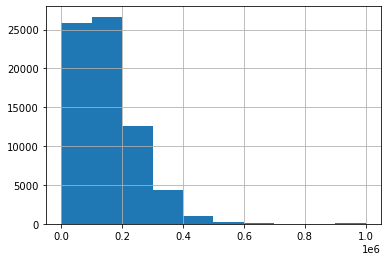

In [17]:
df.mileage.hist();

### modelDate

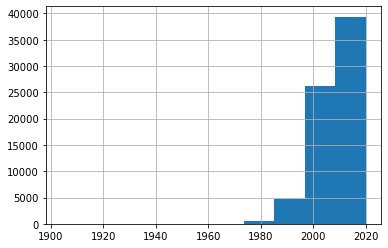

In [18]:
df.modelDate.hist();

### model_name

In [19]:
df.model_name.value_counts()

OCTAVIA       2835
OUTLANDER     1604
LANCER        1544
POLO          1457
A6            1360
              ... 
FAIRLADY Z       1
ARTEON           1
RNESSA           1
SAPPORO          1
LC               1
Name: model_name, Length: 733, dtype: int64

### number of doors

In [20]:
df.numberOfDoors.value_counts()

5.0    41152
4.0    26389
2.0     2167
3.0     1186
0.0        2
Name: numberOfDoors, dtype: int64

In [21]:
df[df.numberOfDoors == 0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,is_train,price
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,NaN,бензин,...,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,False,0
63781,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes-benz/s...,белый,{'id': '0'},"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,{},бензин,...,EUROPEAN,1 владелец,"{'year': 2014, 'month': 2}",Оригинал,задний,Правый,Не требует ремонта,Растаможен,True,12000000


### transmission

In [22]:
df.vehicleTransmission.value_counts()

автоматическая      39222
механическая        14094
вариатор             8832
роботизированная     8748
Name: vehicleTransmission, dtype: int64

### vendor

In [23]:
df.vendor.value_counts()

EUROPEAN    41594
JAPANESE    29302
Name: vendor, dtype: int64

### Руль

In [24]:
df['Руль'].value_counts()

Левый     68327
Правый     2569
Name: Руль, dtype: int64

### Привод

In [25]:
df['Привод'].value_counts()

полный      33294
передний    30737
задний       6865
Name: Привод, dtype: int64

### Владельцы

In [26]:
df['Владельцы'].value_counts()

3 или более    29078
1 владелец     18197
2 владельца    17001
Неизвестно      6620
Name: Владельцы, dtype: int64

### ПТС

In [27]:
df['ПТС'].value_counts()

Оригинал    62254
Дубликат     8642
Name: ПТС, dtype: int64

## Сохраняем данные после обработки

In [28]:
df.to_csv('data1.csv', index=False)

## Отбираем признаки для модели

Первая модель будет очень простая, поэтому выберем прмзнаки, которые не требуют предобработки

In [29]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors', 'engineDisplacement', 'enginePower', 'mileage', ]

## Обучаем первую модель

In [30]:
X = df[df.is_train].drop('price', axis=1).loc[:, cat_cols+num_cols]
y = df[df.is_train].price

In [31]:
X.isna().sum()

bodyType               0
brand                  0
fuelType               0
color                  0
model_name             0
vehicleTransmission    0
vendor                 0
ПТС                    0
Владельцы              0
Привод                 0
Руль                   0
productionDate         0
numberOfDoors          0
engineDisplacement     0
enginePower            0
mileage                0
dtype: int64

In [32]:
model = CatBoostRegressor(cat_features=cat_cols)
model.fit(X, y)

Learning rate set to 0.073939
0:	learn: 2218555.7490826	total: 130ms	remaining: 2m 9s
1:	learn: 2103308.4957258	total: 198ms	remaining: 1m 39s
2:	learn: 1996756.6744303	total: 279ms	remaining: 1m 32s
3:	learn: 1897559.8410884	total: 354ms	remaining: 1m 28s
4:	learn: 1805530.5207517	total: 440ms	remaining: 1m 27s
5:	learn: 1721635.1888356	total: 519ms	remaining: 1m 25s
6:	learn: 1644991.9871962	total: 589ms	remaining: 1m 23s
7:	learn: 1573994.3503350	total: 668ms	remaining: 1m 22s
8:	learn: 1508068.6362676	total: 743ms	remaining: 1m 21s
9:	learn: 1445350.6665958	total: 832ms	remaining: 1m 22s
10:	learn: 1389612.1006850	total: 907ms	remaining: 1m 21s
11:	learn: 1332476.6156228	total: 980ms	remaining: 1m 20s
12:	learn: 1280350.6785417	total: 1.05s	remaining: 1m 19s
13:	learn: 1234431.2309873	total: 1.13s	remaining: 1m 19s
14:	learn: 1190563.7167437	total: 1.21s	remaining: 1m 19s
15:	learn: 1151921.4822695	total: 1.29s	remaining: 1m 19s
16:	learn: 1116973.3105222	total: 1.37s	remaining: 1m

146:	learn: 554684.5511436	total: 10.8s	remaining: 1m 2s
147:	learn: 554415.2347683	total: 10.8s	remaining: 1m 2s
148:	learn: 552683.4043186	total: 10.9s	remaining: 1m 2s
149:	learn: 552403.3592952	total: 11s	remaining: 1m 2s
150:	learn: 552153.8888106	total: 11.1s	remaining: 1m 2s
151:	learn: 549871.2804139	total: 11.1s	remaining: 1m 2s
152:	learn: 549853.0136612	total: 11.2s	remaining: 1m 1s
153:	learn: 549173.3800843	total: 11.2s	remaining: 1m 1s
154:	learn: 548585.0877672	total: 11.3s	remaining: 1m 1s
155:	learn: 546378.2498270	total: 11.4s	remaining: 1m 1s
156:	learn: 545810.4541297	total: 11.5s	remaining: 1m 1s
157:	learn: 545566.6932641	total: 11.6s	remaining: 1m 1s
158:	learn: 545354.5345173	total: 11.6s	remaining: 1m 1s
159:	learn: 545342.4352261	total: 11.7s	remaining: 1m 1s
160:	learn: 544825.9164472	total: 11.8s	remaining: 1m 1s
161:	learn: 542921.6627461	total: 11.9s	remaining: 1m 1s
162:	learn: 541693.9479337	total: 11.9s	remaining: 1m 1s
163:	learn: 541166.0951173	total:

293:	learn: 437663.2450081	total: 21.9s	remaining: 52.7s
294:	learn: 437035.1918619	total: 22s	remaining: 52.6s
295:	learn: 436618.8589808	total: 22.1s	remaining: 52.5s
296:	learn: 436561.8200303	total: 22.1s	remaining: 52.4s
297:	learn: 436507.3388372	total: 22.2s	remaining: 52.3s
298:	learn: 435817.6851489	total: 22.3s	remaining: 52.2s
299:	learn: 435765.3186650	total: 22.3s	remaining: 52.1s
300:	learn: 434704.1130104	total: 22.4s	remaining: 52s
301:	learn: 434562.9068026	total: 22.5s	remaining: 52s
302:	learn: 434512.8123189	total: 22.5s	remaining: 51.8s
303:	learn: 434388.1994778	total: 22.6s	remaining: 51.8s
304:	learn: 434340.3935679	total: 22.7s	remaining: 51.6s
305:	learn: 433790.8700433	total: 22.7s	remaining: 51.6s
306:	learn: 433241.3825201	total: 22.8s	remaining: 51.5s
307:	learn: 433123.7630233	total: 22.8s	remaining: 51.3s
308:	learn: 432480.1381663	total: 22.9s	remaining: 51.3s
309:	learn: 432244.6387903	total: 23s	remaining: 51.2s
310:	learn: 432198.7578753	total: 23s	r

438:	learn: 387698.6656438	total: 32.5s	remaining: 41.5s
439:	learn: 387431.4939605	total: 32.6s	remaining: 41.5s
440:	learn: 387235.6442831	total: 32.6s	remaining: 41.4s
441:	learn: 386875.6141190	total: 32.7s	remaining: 41.3s
442:	learn: 386796.4128323	total: 32.8s	remaining: 41.2s
443:	learn: 386699.9070821	total: 32.9s	remaining: 41.2s
444:	learn: 386420.9403037	total: 33s	remaining: 41.1s
445:	learn: 386344.1773662	total: 33s	remaining: 41s
446:	learn: 386291.2856063	total: 33.1s	remaining: 41s
447:	learn: 385934.1742712	total: 33.2s	remaining: 40.9s
448:	learn: 385866.8686238	total: 33.3s	remaining: 40.8s
449:	learn: 385552.9726173	total: 33.3s	remaining: 40.8s
450:	learn: 385249.9818389	total: 33.4s	remaining: 40.7s
451:	learn: 385013.9273517	total: 33.5s	remaining: 40.6s
452:	learn: 384744.3923241	total: 33.6s	remaining: 40.5s
453:	learn: 384558.2896836	total: 33.7s	remaining: 40.5s
454:	learn: 384403.9490462	total: 33.7s	remaining: 40.4s
455:	learn: 384362.4643794	total: 33.8s

584:	learn: 355192.4286182	total: 43.5s	remaining: 30.9s
585:	learn: 355170.0125077	total: 43.6s	remaining: 30.8s
586:	learn: 355010.0374331	total: 43.7s	remaining: 30.7s
587:	learn: 354772.7436313	total: 43.8s	remaining: 30.7s
588:	learn: 354697.5797087	total: 43.8s	remaining: 30.6s
589:	learn: 354509.4991446	total: 43.9s	remaining: 30.5s
590:	learn: 354492.0647379	total: 44s	remaining: 30.4s
591:	learn: 354391.4150687	total: 44.1s	remaining: 30.4s
592:	learn: 354293.9319252	total: 44.1s	remaining: 30.3s
593:	learn: 354268.5252469	total: 44.2s	remaining: 30.2s
594:	learn: 353988.5954910	total: 44.3s	remaining: 30.2s
595:	learn: 353965.6981108	total: 44.4s	remaining: 30.1s
596:	learn: 353854.2068668	total: 44.5s	remaining: 30s
597:	learn: 353752.1354371	total: 44.5s	remaining: 29.9s
598:	learn: 353741.7922248	total: 44.6s	remaining: 29.9s
599:	learn: 353588.3394227	total: 44.7s	remaining: 29.8s
600:	learn: 353319.3525837	total: 44.8s	remaining: 29.7s
601:	learn: 352850.5056784	total: 4

730:	learn: 335714.7129241	total: 57.6s	remaining: 21.2s
731:	learn: 335639.4627370	total: 57.7s	remaining: 21.1s
732:	learn: 335158.5146247	total: 57.7s	remaining: 21s
733:	learn: 335088.7936167	total: 57.8s	remaining: 20.9s
734:	learn: 334927.0466109	total: 57.9s	remaining: 20.9s
735:	learn: 334891.5063528	total: 58s	remaining: 20.8s
736:	learn: 334730.9668690	total: 58.1s	remaining: 20.7s
737:	learn: 334612.7861193	total: 58.3s	remaining: 20.7s
738:	learn: 334491.1567465	total: 58.4s	remaining: 20.6s
739:	learn: 334409.0944356	total: 58.5s	remaining: 20.6s
740:	learn: 334304.7262839	total: 58.7s	remaining: 20.5s
741:	learn: 334148.1690255	total: 58.9s	remaining: 20.5s
742:	learn: 333885.2867160	total: 59.1s	remaining: 20.4s
743:	learn: 333833.7988905	total: 59.3s	remaining: 20.4s
744:	learn: 333743.6453526	total: 59.4s	remaining: 20.3s
745:	learn: 333715.5202627	total: 59.6s	remaining: 20.3s
746:	learn: 333600.6931448	total: 59.7s	remaining: 20.2s
747:	learn: 333520.1404006	total: 5

874:	learn: 323118.2588008	total: 1m 17s	remaining: 11.1s
875:	learn: 323114.7712841	total: 1m 17s	remaining: 11s
876:	learn: 323027.4385824	total: 1m 17s	remaining: 10.9s
877:	learn: 322908.0621965	total: 1m 17s	remaining: 10.8s
878:	learn: 322882.8049134	total: 1m 17s	remaining: 10.7s
879:	learn: 322836.1905379	total: 1m 17s	remaining: 10.6s
880:	learn: 322773.1514278	total: 1m 17s	remaining: 10.5s
881:	learn: 322655.6566322	total: 1m 17s	remaining: 10.4s
882:	learn: 322629.8834916	total: 1m 18s	remaining: 10.3s
883:	learn: 322476.8738527	total: 1m 18s	remaining: 10.3s
884:	learn: 322446.4527938	total: 1m 18s	remaining: 10.2s
885:	learn: 322403.6563990	total: 1m 18s	remaining: 10.1s
886:	learn: 322345.5150023	total: 1m 18s	remaining: 9.98s
887:	learn: 322340.3719438	total: 1m 18s	remaining: 9.89s
888:	learn: 322132.1407829	total: 1m 18s	remaining: 9.81s
889:	learn: 321964.8412277	total: 1m 18s	remaining: 9.72s
890:	learn: 321929.8329435	total: 1m 18s	remaining: 9.63s
891:	learn: 3218

### Анализируем результат модели на обучении

In [33]:
model.get_best_score()

{'learn': {'RMSE': 314071.1410558236}}

ну так себе разброс  в 314000

### Признаки, отобранные моеделью

In [34]:
pd.Series(model.get_feature_importance(), index=model.feature_names_).sort_values(ascending=False)

enginePower            26.240065
productionDate         18.728183
mileage                15.300073
engineDisplacement     13.365421
brand                  10.172462
Привод                  5.018099
model_name              2.939721
fuelType                2.423767
bodyType                1.902101
Владельцы               1.823259
vehicleTransmission     1.173234
color                   0.609905
vendor                  0.138881
numberOfDoors           0.117047
ПТС                     0.042506
Руль                    0.005277
dtype: float64

## Сделаем сабмит в kaggle

In [35]:
X_test = df[~df.is_train].drop('price', axis=1).loc[:, cat_cols+num_cols]

In [36]:
def make_submit(model, X_test, submit_file, index=None):
    pred = np.round(model.predict(X_test))
    answer = pd.Series(pred, index=index, name='price')
    answer.to_csv(submit_file, index_label='sell_id')
    
    

In [37]:
make_submit(model, X_test, submit_file='predict.csv', index=df[~df.is_train].sell_id)

Ну так себе результат, 22% ошибки. Но есть над чем поработать.

# Выводы

* У нас получилось построить простую модель, которая более-менее предсказывает цену на автомобили
* Использовали CatBoost с дефолтными настройками
* Самыми топовыми признаками модели стали: enginePower, productionDate, mileage. Что впринципе логично

# Дальнейшие шаги

* Будем работать с добавлением новых признаков
* Будем использовать и настраивать другие модели